In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#algorithms
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.pipeline import Pipeline
import sklearn.metrics
from sklearn.naive_bayes import GaussianNB

#data
pb = pd.read_csv('pb.data', delimiter='\t', names=['M/F/C','SPKR','Phoneme-Number',	'Phoneme-Ascii',	'F0',	'F1',	'F2',	'F3'], dtype={'F0':int,	'F1':int,	'F2':int,	'F3':int})
pb.head()

,M/F/C,SPKR,Phoneme-Number,Phoneme-Ascii,F0,F1,F2,F3
0,1,1,1,IY,160,240,2280,2850
1,1,1,1,IY,186,280,2400,2790
2,1,1,2,IH,203,390,2030,2640
3,1,1,2,IH,192,310,1980,2550
4,1,1,3,EH,161,490,1870,2420


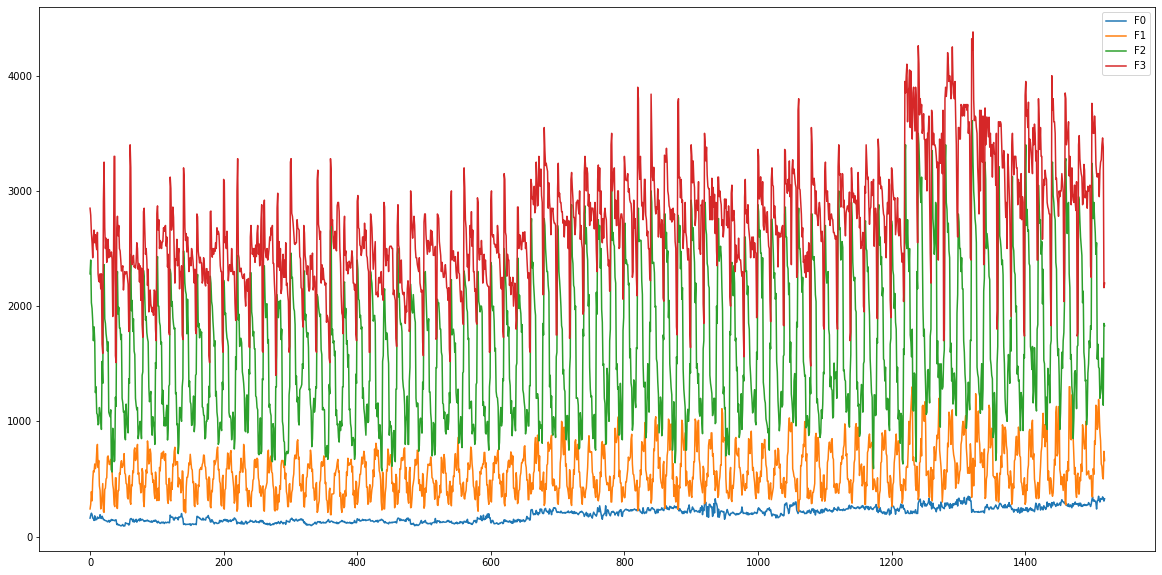

In [3]:
plt.figure(figsize=(20,10))
plt.plot(pb['F0'], label='F0')
plt.plot(pb['F1'], label='F1')
plt.plot(pb['F2'], label='F2')
plt.plot(pb['F3'], label='F3')
plt.legend()

In [4]:
X = pb.drop(['Phoneme-Number','Phoneme-Ascii'], axis=1)
y = pb['Phoneme-Number']

# Train-test split

In [5]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# pb_train = pb[pb.index % 10 < 8]
# pb_val = pb[pb.index % 10 == 8]
# pb_test = pb[pb.index % 10 == 9]


# for CV
from sklearn.model_selection import StratifiedKFold

stratified_kfold = StratifiedKFold(n_splits=5,
                                       shuffle=True,
                                       random_state=11)

In [6]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

In [7]:
# Optional scaling
# Note: scaling the data in this dataset yields worse accuracy in most cases 

from sklearn import preprocessing

switch = False

if switch == True:
    quantile_transformer = preprocessing.QuantileTransformer(random_state=0)
    
    fitted_train = quantile_transformer.fit_transform(X_train.drop(['M/F/C','SPKR'], axis = 1))
    fitted_test = quantile_transformer.fit_transform(X_test.drop(['M/F/C','SPKR'], axis = 1))
    
    X_train = pd.concat([X_train[['M/F/C','SPKR']].reset_index().drop(['index'], axis=1), 
                         pd.DataFrame(fitted_train, columns=[	'F0',	'F1',	'F2',	'F3'])], axis = 1, ignore_index=True)
    
    X_test = pd.concat([X_test[['M/F/C','SPKR']].reset_index().drop(['index'], axis=1), 
                        pd.DataFrame(fitted_test, columns=[	'F0',	'F1',	'F2',	'F3'])], axis = 1, ignore_index=True)

# Model 1: Taking every record into consideration

(Gaussian) Naive Bayes

In [8]:
from sklearn.naive_bayes import GaussianNB

clf = GaussianNB()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
bayes_acc = round(sklearn.metrics.accuracy_score(y_test, y_pred),2)

print(f'Accuracy: {round(sklearn.metrics.balanced_accuracy_score(y_test, y_pred),2)}')

Accuracy: 0.76


Decision Tree

In [9]:
clf = DecisionTreeClassifier(criterion = "gini", random_state = 42, max_depth=5, min_samples_leaf=5)
clf = clf.fit(X_train, y_train)
print(f'Mean CV Score: {np.mean(cross_val_score(clf, X_train, y_train, cv=10))}')

tree_pred = clf.predict(X_test)
print(f'Test Accuracy: {round(sklearn.metrics.balanced_accuracy_score(y_test, tree_pred),4)}')

Mean CV Score: 0.7463020609703734
Test Accuracy: 0.7263


Random Forest

In [10]:
rf = RandomForestClassifier(n_estimators = 50, max_depth=10, random_state = 42)
rf.fit(X_train, y_train)
print(f'Mean CV Score: {np.mean(cross_val_score(clf, X_train, y_train, cv=10))}')

rf_pred = rf.predict(X_test)
print(f'Test Accuracy: {round(sklearn.metrics.balanced_accuracy_score(y_test, rf_pred),4)}')

Mean CV Score: 0.7463020609703734
Test Accuracy: 0.9136


kNN

In [11]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
print(np.mean(cross_val_score(knn, X_train, y_train, cv=10)))

knn_pred = knn.predict(X_test)
accuracy_score(y_test,knn_pred)

0.8289555603263203


0.8618421052631579

In [12]:
import warnings
warnings.filterwarnings('ignore')

xgb = XGBClassifier(random_state=42)
xgb.fit(X_train, y_train)
print(np.mean(cross_val_score(xgb, X_train, y_train, cv=10)))

xgb_pred = xgb.predict(X_test)
accuracy_score(y_test,xgb_pred)

0.8669708029197081


0.9078947368421053

In [13]:
log_reg = LogisticRegression(random_state=42)
log_reg.fit(X_train,y_train);
#print(np.mean(cross_val_score(log_reg, X_train, y_train, cv=10)))

log_pred = log_reg.predict(X_test)
accuracy_score(y_test,log_pred)

0.8618421052631579

### Gridsearch

Random Forest

In [14]:
from sklearn.model_selection import GridSearchCV

params = {'max_depth' : [8,10,15], 'criterion':['gini', 'entropy']}

rfc = RandomForestClassifier(n_estimators = 100, random_state=42)

clf = GridSearchCV(rfc, params, cv=5, scoring='accuracy', n_jobs=-1)
clf.fit(X_train, y_train)

clf.best_params_

{'criterion': 'entropy', 'max_depth': 15}

In [15]:
rf3 = RandomForestClassifier(n_estimators = 100, max_depth=10, criterion='entropy', random_state = 42)
rf3.fit(X_train, y_train)
print(np.mean(cross_val_score(rf3, X_train, y_train, cv=10)))

rf_pred3 = rf3.predict(X_test)
accuracy_score(y_test,rf_pred3)

0.8720588235294118


0.9276315789473685

XGBOOST

In [16]:
xgb_model = XGBClassifier(random_state=42)

xgb_params = {'eta':[0.01,0.1,0.5], 'max_depth':[5,10,15]}

model = GridSearchCV(estimator = xgb_model, param_grid = xgb_params, scoring='accuracy', cv=5, n_jobs=-1)
model.fit(X_train,y_train)

model.best_params_

{'eta': 0.01, 'max_depth': 10}

In [17]:
xgb = XGBClassifier(eta=0.01, max_depth=10, random_state=42)
xgb.fit(X_train, y_train)
print(np.mean(cross_val_score(xgb, X_train, y_train, cv=10)))

xgb_pred = xgb.predict(X_test)
accuracy_score(y_test,xgb_pred)

0.8691337483898668


0.9144736842105263

# Comparsion of the simple models and testing the best one

In [26]:
!pip install fast_ml

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 42 kB 734 kB/s 


In [33]:
from fast_ml.model_development import train_valid_test_split

X_train_1, y_train_1, X_valid, y_valid, X_test_1, y_test_1 = train_valid_test_split( pb.drop(['Phoneme-Ascii'],  axis=1), target = 'Phoneme-Number', 
                                                                            train_size=0.8, valid_size=0.1, test_size=0.1, random_state = 42)

print(X_train_1.shape), print(y_train_1.shape)
print(X_valid.shape), print(y_valid.shape)
print(X_test_1.shape), print(y_test_1.shape)

(1216, 6)
(1216,)
(152, 6)
(152,)
(152, 6)
(152,)


(None, None)

In [35]:
from sklearn.naive_bayes import GaussianNB

clf = GaussianNB()
clf.fit(X_train_1, y_train_1)
y_pred_1 = clf.predict(X_valid)
bayes_acc = round(sklearn.metrics.accuracy_score(y_valid, y_pred_1),2)

print(f'Validation Accuracy off Naive Bayes: {round(sklearn.metrics.balanced_accuracy_score(y_valid, y_pred_1),2)}')

clf = DecisionTreeClassifier(criterion = "gini", random_state = 42, max_depth=5, min_samples_leaf=5)
clf = clf.fit(X_train_1, y_train_1)

tree_pred_1 = clf.predict(X_valid)
print(f'Validation Accuracy of Decision Tree: {round(sklearn.metrics.balanced_accuracy_score(y_valid, tree_pred_1),4)}')

rf = RandomForestClassifier(n_estimators = 50, max_depth=10, random_state = 42)
rf.fit(X_train_1, y_train_1)

rf_pred = rf.predict(X_valid)
print(f'Validation Accuracy of Random Forest: {round(sklearn.metrics.balanced_accuracy_score(y_valid, rf_pred),4)}')

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_1, y_train_1)

knn_pred = knn.predict(X_valid)
print(f'Validation Accuracy of Knn: {round(accuracy_score(y_valid,knn_pred))}')

warnings.filterwarnings('ignore')

xgb = XGBClassifier(random_state=42)
xgb.fit(X_train_1, y_train_1)

xgb_pred = xgb.predict(X_valid)
print(f'Validation Accuracy of XGboost: {round(accuracy_score(y_valid,xgb_pred))}')

log_reg = LogisticRegression(random_state=42)
log_reg.fit(X_train_1,y_train_1);

log_pred = log_reg.predict(X_valid)
print(f'Validation Accuracy of Logistic Regression: {round(accuracy_score(y_valid,log_pred))}')

Validation Accuracy off Naive Bayes: 0.79
Validation Accuracy of Decision Tree: 0.7172
Validation Accuracy of Random Forest: 0.9081
Validation Accuracy of Knn: 1
Validation Accuracy of XGboost: 1
Validation Accuracy of Logistic Regression: 1


# Model 2: Dropping the asterisk marked rows and with using CV

In [18]:
X = pb.drop(['Phoneme-Number'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

X_train_new = X_train[~X_train['Phoneme-Ascii'].str.contains('*',regex=False)]
X_train_new = X_train_new.drop(['Phoneme-Ascii'], axis=1)
y_train_new = y_train[X_train_new.index]

X_test = X_test.drop(['Phoneme-Ascii'], axis=1)

print(len(X_train),len(X_train_new))

1368 1072


In [19]:
# Optional scaling
# Note: the training takes more time with the scaled data 

switch = False

if switch == True:
    quantile_transformer = preprocessing.QuantileTransformer(random_state=0)
    
    fitted_train = quantile_transformer.fit_transform(X_train_new.drop(['M/F/C','SPKR'], axis = 1))
    fitted_test = quantile_transformer.fit_transform(X_test.drop(['M/F/C','SPKR'], axis = 1))
    
    X_train_new = pd.concat([X_train_new[['M/F/C','SPKR']].reset_index().drop(['index'], axis=1), 
                         pd.DataFrame(fitted_train, columns=[	'F0',	'F1',	'F2',	'F3'])], axis = 1, ignore_index=True)
    
    X_test = pd.concat([X_test[['M/F/C','SPKR']].reset_index().drop(['index'], axis=1), 
                        pd.DataFrame(fitted_test, columns=[	'F0',	'F1',	'F2',	'F3'])], axis = 1, ignore_index=True)

### Algorithms

Logistic Regression

In [20]:
pipeline = Pipeline(steps = [['classifier', LogisticRegression(class_weight = "balanced", random_state=0, max_iter = 5000, multi_class = 'ovr')]])
param_grid = {'classifier__C':[i for i in [0.001, 0.01, 0.1, 1, 10, 50]], 'classifier__solver':['sag','saga']}

log_grid_search = GridSearchCV(estimator=pipeline,
                               param_grid=param_grid,
                               scoring='accuracy',
                               cv=stratified_kfold,
                               n_jobs=-1)


log_grid_search.fit(X_train_new, y_train_new)
cv_score = log_grid_search.best_score_
log_acc = log_grid_search.score(X_test, y_test)
y_pred = log_grid_search.predict(X_test)
print("Logistic Regression:")
print({'cv_score':cv_score, 'test_score':log_acc})
print("Params:")
print(log_grid_search.best_params_)

print("")
print(f'Accuracy: {round(sklearn.metrics.accuracy_score(y_test, y_pred),2)}')
print(f'Precision: {round(sklearn.metrics.precision_score(y_test, y_pred, average = "weighted"),2)}')
print(f'Recall: {round(sklearn.metrics.recall_score(y_test, y_pred, average = "weighted"),2)}')

Logistic Regression:
{'cv_score': 0.8068898065637905, 'test_score': 0.8421052631578947}
Params:
{'classifier__C': 0.001, 'classifier__solver': 'sag'}

Accuracy: 0.84
Precision: 0.86
Recall: 0.84


kNN

In [21]:
pipeline = Pipeline(steps = [['classifier', KNeighborsClassifier(metric="euclidean")]])
param_grid = {'classifier__n_neighbors':[i for i in range(1,15)], 'classifier__algorithm':['kd_tree', 'brute']}

knn_eu_grid_search = GridSearchCV(estimator=pipeline,
                               param_grid=param_grid,
                               scoring='accuracy',
                               cv=stratified_kfold,
                               n_jobs=-1)


knn_eu_grid_search.fit(X_train_new, y_train_new)
cv_score = knn_eu_grid_search.best_score_
knn_eu = knn_eu_grid_search.score(X_test, y_test)
print("Euclidian kNN:")
print({'cv_score':cv_score, 'test_score':knn_eu})
print("Params:")
print(knn_eu_grid_search.best_params_)

Euclidian kNN:
{'cv_score': 0.8852771136709412, 'test_score': 0.875}
Params:
{'classifier__algorithm': 'kd_tree', 'classifier__n_neighbors': 1}


In [22]:
# TODO: Ezt is CV-zni

# xgb2 = XGBClassifier(random_state=42)
# xgb2.fit(X_train_new, y_train_new)
# print(np.mean(cross_val_score(xgb2, X_train_new, y_train_new, cv=10)))

# xgb_pred2 = xgb2.predict(X_test)
# accuracy_score(y_test,xgb_pred2)

SVM

In [23]:
pipeline = Pipeline(steps = [['classifier', SVC(class_weight = "balanced", random_state=0, decision_function_shape = 'ovr')]])
param_grid = {'classifier__C':[i for i in [0.001, 0.01, 0.1, 1, 10, 50]], 'classifier__kernel':['linear','poly','rbf']}

SVM_grid_search = GridSearchCV(estimator=pipeline,
                               param_grid=param_grid,
                               scoring='accuracy',
                               cv=stratified_kfold,
                               n_jobs=-1)


SVM_grid_search.fit(X_train_new, y_train_new)
cv_score = SVM_grid_search.best_score_
SVM_acc = SVM_grid_search.score(X_test, y_test)
y_pred = SVM_grid_search.predict(X_test)
print("SVM:")
print({'cv_score':cv_score, 'test_score':SVM_acc})
print("Params:")
print(SVM_grid_search.best_params_)

print("")
print(f'Accuracy: {round(sklearn.metrics.accuracy_score(y_test, y_pred),2)}')
print(f'Precision: {round(sklearn.metrics.precision_score(y_test, y_pred, average = "weighted"),2)}')
print(f'Recall: {round(sklearn.metrics.recall_score(y_test, y_pred, average = "weighted"),2)}')


KeyboardInterrupt: ignored

Normal Gradient Boosting

In [ ]:
pipeline = Pipeline(steps = [['classifier', GradientBoostingClassifier(random_state=0)]])
param_grid = {'classifier__learning_rate':[0.001, 0.01, 0.1, 1],
              'classifier__n_estimators':[5*i for i in range(1,10)],
              'classifier__max_depth':[3,4,5]}

grad_grid_search = GridSearchCV(estimator=pipeline,
                               param_grid=param_grid,
                               scoring='accuracy',
                               cv=stratified_kfold,
                               n_jobs=-1)


grad_grid_search.fit(X_train_new, y_train_new)
cv_score = grad_grid_search.best_score_
grad_acc = grad_grid_search.score(X_test, y_test)
y_pred = grad_grid_search.predict(X_test)
print("Gradient Boosting:")
print({'cv_score':cv_score, 'test_score':grad_acc})
print("Params:")
print(grad_grid_search.best_params_)

print("")
print(f'Accuracy: {round(sklearn.metrics.accuracy_score(y_test, y_pred),2)}')
print(f'Precision: {round(sklearn.metrics.precision_score(y_test, y_pred, average = "weighted"),2)}')
print(f'Recall: {round(sklearn.metrics.recall_score(y_test, y_pred, average = "weighted"),2)}')